# How to Access Metal API from Python?




There are several ways to access Metal API from Python. I chose to access it via Swift (It's standard way). 

Here are the instructions for builiding swift and load dylib from python.

<!-- PythonからMetalにアクセスするにはいくつかの方法がありますが、私はSwiftを介してMetalにアクセスすることにしました。
PythonからSwiftのプログラムを実行するフローは次のようになります。 -->

1. Writing Swift Program that use Metal
    * Writing Metal Shaders
        * Example: [Shaders.metal](https://github.com/noppoMan/python-metal-benchmark/blob/gh-pages/PyMetalBridge/Sources/PyMetalBridge/Shaders.metal)
        * Documents: [Metal-Shading-Language-Specification](https://developer.apple.com/metal/Metal-Shading-Language-Specification.pdf)
    * [Build Metal Sahders](https://developer.apple.com/documentation/metal/libraries/building_a_library_with_metal_s_command-line_tools)
    * [Load .metallib from Swift and wiriting pipeline program for it](https://github.com/noppoMan/python-metal-benchmark/blob/gh-pages/PyMetalBridge/Sources/PyMetalBridge/PyMetalBridge.swift#L11)
2. [Build and export Swift program as dynamic library](https://github.com/noppoMan/python-metal-benchmark/blob/gh-pages/PyMetalBridge/README.md)
3. Load dylib(created at step.2) in Python with [ctypes](https://docs.python.org/3/library/ctypes.html)


# Example

In [1]:
import platform
import numpy as np
import ctypes
import time
import math
import time
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
!python --version

Python 3.8.0


In [3]:
# Loads dylib like dlopen
swift_fun = ctypes.CDLL("./PyMetalBridge/.build/release/libPyMetalBridge.dylib")

# decleare arguments for function pointer
swift_fun.swift_sigmoid_on_gpu.argtypes = [
    ctypes.POINTER(ctypes.c_float), 
    ctypes.POINTER(ctypes.c_float), 
    ctypes.c_int
]

def swift_sigmoid_on_gpu(input_array):
    input_ptr = input_array.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    output_mutable_ptr = (ctypes.c_float * len(input_array))()
    swift_fun.swift_sigmoid_on_gpu(input_ptr, output_mutable_ptr, len(input_array))
    return np.array(output_mutable_ptr)

In [4]:
input_array = np.random.uniform(-1, 1, 100).astype("float32") # data type have to be float32 for GPU
swift_result = swift_sigmoid_on_gpu(input_array)
swift_result

array([0.6631254 , 0.34386754, 0.47468635, 0.42544967, 0.55456567,
       0.37789935, 0.28491375, 0.64523005, 0.71711004, 0.4564191 ,
       0.7069524 , 0.36841398, 0.38514578, 0.69130397, 0.39588487,
       0.3833351 , 0.67351717, 0.7153257 , 0.46847546, 0.6175204 ,
       0.63834405, 0.5888168 , 0.5403071 , 0.43178084, 0.56773007,
       0.6346955 , 0.71699405, 0.6447153 , 0.4438148 , 0.7230937 ,
       0.30244544, 0.61988413, 0.6813066 , 0.47608435, 0.35673964,
       0.52870345, 0.5452527 , 0.42378187, 0.34905508, 0.31308657,
       0.6904162 , 0.60655206, 0.60422814, 0.5270733 , 0.5628574 ,
       0.6087762 , 0.5695692 , 0.40402642, 0.49489447, 0.68704504,
       0.71259475, 0.2739107 , 0.29176977, 0.39175686, 0.45773083,
       0.45625463, 0.5739437 , 0.36191016, 0.6900716 , 0.46827307,
       0.31729132, 0.7124829 , 0.5857014 , 0.64435226, 0.6499076 ,
       0.4520865 , 0.47886142, 0.3448555 , 0.37214863, 0.5798032 ,
       0.37759492, 0.70344627, 0.61530274, 0.42618215, 0.43847

It seems to work fine, but you may be wondering if the calculation result is correct? So, let's implement a sigmoid function in python to verify and compare the result.

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

python_result = sigmoid(input_array).astype("float32")

### Validate Results with cosine_similarity

Let's compare swift_result and python_results by cosine_similarity to validate calculation justification.

In [6]:
# Returns a matrix whose elements are all 1, if the 2 vectors are same
cosine_similarity([python_result, python_result])

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [7]:
cosine_similarity([swift_result, python_result])

array([[0.99999994, 1.        ],
       [1.        , 1.        ]], dtype=float32)

Wow! almost same!

# Benchmarking

#### Test Machine Spec: Apple MacBook Pro (16-inch, 2019)

* Processor: 2.4 GHz 8-Core Intel Core i9
* RAM: 64 GB 2667 MHz DDR
* GPU: AMD Radeon Pro 5500M（4GB)

<!-- Pythonからmetalを実行できたとしても、実行速度が速くならばければコストをかけるメリットがありません。よって、複雑な計算をpure pythonとmetalの両方で行って、そのパフォーマンスを比較してみましょう。今回は、$[-1, 1]$からランダムに10万件のサンプルを取り出した数値に対して、次のフーリエ級数として展開し、その後一階微分するようなことを
試みます。 -->

Even if we can access Metal API from Python, there is no point unless the processing performance improves. So let's run complex calculations in both Pure Python and Metal to compare their performance. This time, we expand the Fourier series(as shown bellow) for the numerical values of 100,000 samples created with `np.arange(-50, 50, 0.001)`, and then perform the 1-th numerical differentiation.

#### fourier series
$$
f(x) = \sin(x) + \frac{1}{3}\sin(3x) + \frac{1}{5}\sin(5x) + \frac{1}{7}\sin(7x) + \cdots ++ \frac{1}{99}\sin(99x)
$$

In [8]:
def f(x):
    approximate = 0
    for coeff in range(1, 100, 2):
        approximate += (1/coeff)*np.sin(coeff*x)
        
    return approximate

#### numerical differential 

$$
\frac{df}{dx} = \frac{f(x + \Delta) - f(x - \Delta)}{2 \Delta}
$$

In [9]:
def differential(f, x):
    delta = 1e-4
    return (f(x+delta) - f(x-delta)) / 2*delta

## Benchmarking of Pure Python and numpy

In [10]:
def python_differential_using_for_loop(input_array):
    result = []
    for x in input_array:
        result.append(differential(f, x))
    
    return np.array(result)

In [11]:
input_array = np.arange(-50, 50, 0.001).astype("float32") # have to be float32 for GPU
input_array.shape

(100000,)

### Pure Python

In [12]:
%%time
python_result = python_differential_using_for_loop(input_array)

CPU times: user 15.8 s, sys: 35.6 ms, total: 15.9 s
Wall time: 15.9 s


### Optimized calculation with numpy.apply_along_axis

In [13]:
%%time
optimized_python_result = np.apply_along_axis(lambda x: differential(f, x), 0, input_array)

CPU times: user 20.5 ms, sys: 1.66 ms, total: 22.2 ms
Wall time: 21.1 ms


It became much faster by using `np.apply_along_axis`. Therefore, I use `np.apply_along_axis` for benchmarking target for this time.

## Benchmarking of Python + Swift and Metal

### fourier series and numerical differential in Metal Shders

```c++
inline float f(const float x) {
    float approximate = 0;
    for(int coeff = 1; coeff < 100; coeff+=2) {
        approximate += ((float)1/coeff)*sin(coeff*x);
    }
    return approximate;
}

constant float delta = 1e-4;

kernel void differential(const device float *inVector [[ buffer(0) ]],
                    device float *outVector [[ buffer(1) ]],
                    uint id [[ thread_position_in_grid ]]) {
    
    float x = inVector[id];
    outVector[id] = (f(x+delta) - f(x-delta)) / 2.0f*delta;
}
```


### Loads dylib and declares swift function

In [14]:
swift_fun = ctypes.CDLL("./PyMetalBridge/.build/release/libPyMetalBridge.dylib")

# decleare arguments type
swift_fun.swift_differential_on_gpu.argtypes = [
    ctypes.POINTER(ctypes.c_float), 
    ctypes.POINTER(ctypes.c_float),
    ctypes.c_int
]

def swift_differential_on_gpu(input_array):
    input_ptr = input_array.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    output_mutable_ptr = (ctypes.c_float * len(input_array))()
    swift_fun.swift_differential_on_gpu(input_ptr, output_mutable_ptr, len(input_array))
    return np.array(output_mutable_ptr)

## First Time(Cold)

In [15]:
%%time
swift_result = swift_differential_on_gpu(input_array)

CPU times: user 1.42 ms, sys: 1.73 ms, total: 3.15 ms
Wall time: 931 ms


## Second Time(Hot)

In [16]:
%%time
swift_result = swift_differential_on_gpu(input_array)

CPU times: user 827 µs, sys: 1.08 ms, total: 1.9 ms
Wall time: 1.14 ms


As results, numpy took `21.1`, but Python + Metal took `1.14 ms` at second time. So, Metal is incredibly faster!

# Validate Results

In [17]:
swift_result.shape, python_result.shape

((100000,), (100000,))

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([python_result, python_result])

array([[1., 1.],
       [1., 1.]])

In [19]:
cosine_similarity([python_result, optimized_python_result])

array([[1.        , 0.99997607],
       [0.99997607, 1.        ]])

In [20]:
cosine_similarity([swift_result, python_result.astype("float32")])

array([[1.0000103, 0.9999868],
       [0.9999868, 1.0000101]], dtype=float32)

Wow! almost same.

# Performance comparison between Numpy and Metal in 10 iterations

In [21]:
def measure(f):
    elapsed_logs = []
    for i in range(10):
        input_array = np.random.uniform(-50, 50, 100000).astype("float32")
        start = time.time()
        f(input_array)
        end = time.time()
        elapsed_logs.append(end - start)
        
    return elapsed_logs

In [22]:
# np.apply_along_axis
python_results = measure(lambda input_array: np.apply_along_axis(lambda x: differential(f, x), 0, input_array))

In [23]:
print("Python time elapsed (second)")
python_results

Python time elapsed (second)


[0.017614126205444336,
 0.017297744750976562,
 0.01820516586303711,
 0.015767812728881836,
 0.01654195785522461,
 0.015439271926879883,
 0.014621973037719727,
 0.014592885971069336,
 0.014617204666137695,
 0.015677928924560547]

In [24]:
# Metal
swift_results = measure(swift_differential_on_gpu)

In [25]:
print("Metal time elapsed (second)")
swift_results

Metal time elapsed (second)


[0.002980947494506836,
 0.0008182525634765625,
 0.0009021759033203125,
 0.0008540153503417969,
 0.0008161067962646484,
 0.0007848739624023438,
 0.0007979869842529297,
 0.0007920265197753906,
 0.0007829666137695312,
 0.0008709430694580078]

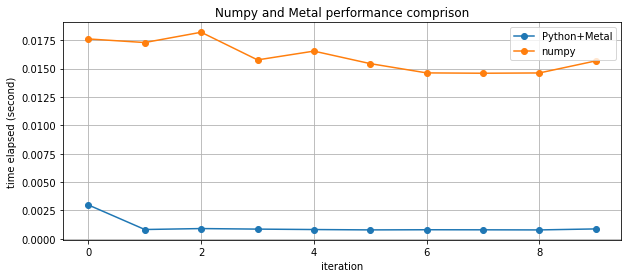

In [32]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(range(10), swift_results, '-o', label='Python+Metal')
ax.plot(range(10), python_results, '-o', label='numpy')
ax.set_title('Numpy and Metal performance comprison')
ax.set_xlabel('iteration')
ax.set_ylabel('time elapsed (second)')
ax.grid(True)
ax.legend()